## 0.下準備

#### 1)ライブラリのインストール  
 - pytorch のインストール
   https://pytorch.org/

#### 2)gitのクローンをコピー
　https://github.com/YutaroOgawa/pytorch_advanced
 
#### 3)utilsをコピー
 - 2_objectdetection\utilsをコピー 
 - Errorが出る場合は、一部ファイルを変更

#### 4)学習済みweight取得
https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth

## 1.ライブラリ読み込み

In [1]:
# パッケージのimport
import os.path as osp
import os
import sys
import random
import time
import glob
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data

from utils.ssd_model import VOCDataset, DataTransform, Anno_xml2list, od_collate_fn
from utils.ssd_model import SSD
from utils.ssd_model import MultiBoxLoss

## 2. データ準備

In [2]:
# データのリストを取得
data_path = './od_dogs'
filename_list = [os.path.split(f)[1].split('.')[0] for f in glob.glob(f'{data_path}/*.xml')]
filename_list_train, filename_list_val = train_test_split(filename_list, test_size=0.1)
train_img_list = [f'{data_path}/{f}.jpg' for f in filename_list_train]
train_anno_list = [f'{data_path}/{f}.xml' for f in filename_list_train]
val_img_list = [f'{data_path}/{f}.jpg' for f in filename_list_val]
val_anno_list = [f'{data_path}/{f}.xml' for f in filename_list_val]

# Datasetを作成
voc_classes = ['dog']

color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズ

train_dataset = VOCDataset(train_img_list, 
                           train_anno_list, 
                           phase="train", 
                           transform=DataTransform(input_size, color_mean), 
                           transform_anno=Anno_xml2list(voc_classes))
val_dataset = VOCDataset(val_img_list, 
                         val_anno_list, 
                         phase="val", 
                         transform=DataTransform(input_size, color_mean), 
                         transform_anno=Anno_xml2list(voc_classes))

# DataLoaderを作成する
train_dataloader = data.DataLoader(train_dataset, 
                                   batch_size=32, 
                                   shuffle=True, 
                                   collate_fn=od_collate_fn)
val_dataloader = data.DataLoader(val_dataset, 
                                 batch_size=3, 
                                 shuffle=False, 
                                 collate_fn=od_collate_fn)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## 3.ロス、モデルなど準備

In [3]:
# SSD300の設定
ssd_cfg = {
    'num_classes': 2,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [21, 45, 99, 153, 207, 261],  # DBOXの大きさを決める
    'max_sizes': [45, 99, 153, 207, 261, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

# SSDの初期の重みを設定
vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssdのその他のネットワークの重みはHeの初期値で初期化
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)
        
# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)
print('ネットワーク設定完了：学習済みの重みをロードしました')

使用デバイス： cuda:0
ネットワーク設定完了：学習済みの重みをロードしました


In [4]:
# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

## 4.学習

In [5]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    min_loss = 9999
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            # データローダーからminibatchずつ取り出すループ
            with tqdm(dataloaders_dict[phase], desc=phase, file=sys.stdout) as iterator:
                for images, targets in iterator:

                    # GPUが使えるならGPUにデータを送る
                    images = images.to(device)
                    targets = [ann.to(device)
                               for ann in targets]  # リストの各要素のテンソルをGPUへ

                    # optimizerを初期化
                    optimizer.zero_grad()

                    # 順伝搬（forward）計算
                    with torch.set_grad_enabled(phase == 'train'):
                        # 順伝搬（forward）計算
                        outputs = net(images)

                        # 損失の計算
                        loss_l, loss_c = criterion(outputs, targets)
                        loss = loss_l + loss_c

                        # 訓練時はバックプロパゲーション
                        if phase == 'train':
                            loss.backward()
                            nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                            optimizer.step()
                            epoch_train_loss += loss.item()
                            iteration += 1
                        # 検証時
                        else:
                            epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print(f'epoch {epoch+1}/{num_epochs} {(t_epoch_finish - t_epoch_start):.4f}sec || train_Loss:{epoch_train_loss:.4f} val_Loss:{epoch_val_loss:.4f}')
        t_epoch_start = time.time()

        # vallossが小さい、ネットワークを保存する
        if min_loss>epoch_val_loss:
            min_loss=epoch_val_loss
            torch.save(net.state_dict(), 'weights/ssd_best.pth')

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和


In [6]:
# 学習・検証を実行する
num_epochs= 200
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.84it/s]
epoch 1/200 19.7787sec || train_Loss:53.8755 val_Loss:38.9169
val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.75it/s]
epoch 2/200 6.4789sec || train_Loss:32.0594 val_Loss:29.4087
val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.74it/s]
epoch 3/200 6.6353sec || train_Loss:25.9026 val_Loss:28.2379
val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.97it/s]
epoch 4/200 5.8647sec || train_Loss:23.3002 val_Loss:26.7890
val: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.85it/s]
epoch 5/200 5.8115sec || train_Loss:21.8037 val_Loss:26.0588
val: 100%|█████████████████████████████████████████████████████████████████████

## 5.モデルを読み込んで推論

In [7]:
from utils.ssd_model import SSD
from utils.ssd_model import DataTransform
import cv2  # OpenCVライブラリ
import matplotlib.pyplot as plt 
import numpy as np
import torch
from utils.ssd_predict_show import SSDPredictShow

voc_classes = ['dog']

# SSDネットワークモデル
ssd_cfg = {
    'num_classes': 2,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [21, 45, 99, 153, 207, 261],  # DBOXの大きさを決める
    'max_sizes': [45, 99, 153, 207, 261, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}
net = SSD(phase="inference", cfg=ssd_cfg)

# SSDの学習済みの重みを設定
net_weights = torch.load('./weights/ssd_best.pth', map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


box [1021.67435861 1905.61043072 1654.0459199  2822.72472668]
label dog
score 0.92002684


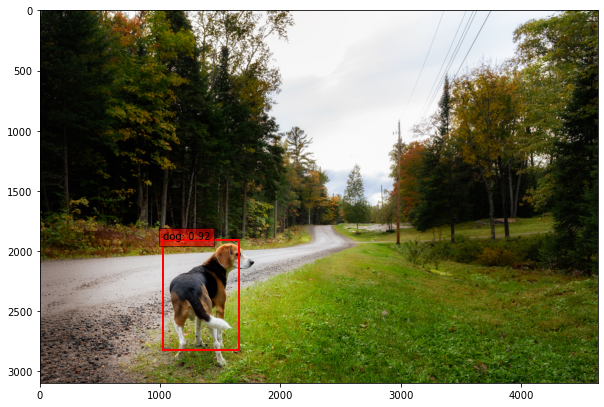

In [8]:
# ファイルパス
image_file_path = "./dog_test.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.5)

# ボックスなどを取得
rgb_img, predict_bbox, pre_dict_label_index, scores = ssd.ssd_predict(image_file_path)
for i in range(len(predict_bbox)):
    print('box', predict_bbox[i])
    print('label', voc_classes[pre_dict_label_index[i]])
    print('score', scores[i])